# Can we predict strain type (sativa/indica) from strain descriptions?

In [8]:
# GENERAL
import numpy as np
import pandas as pd

# NLP
from collections import Counter
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# MODELING
from sklearn import metrics, tree, linear_model, neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
import eli5
from eli5.sklearn import PermutationImportance

# GRAPHICS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 0. Load df, set columns

In [9]:
# LOAD df, SET COLUMNS
df_raw = pd.read_csv('data/df_strain_me_v2.csv', encoding = "UTF-8")

cols = ['strain', 'cluster', 'lean', 'strain_type', 'Strain_description']
df = df_raw[cols].copy()
df.columns = ['Strain', 'Cluster', 'Lean', 'Strain_type', 'Strain_description'] # Rename columns
df.index = df['Strain']
df.drop('Strain', axis=1, inplace=True)

# REMOVE NULL Strain_description columns
df.dropna(subset=['Strain_description'], inplace=True)
df.head()

,Cluster,Lean,Strain_type,Strain_description
Strain,,,,
$100 OG,0,0.50,hybrid,$100 OG is a 50/50 hybrid strain that packs a ...
'98 Aloha White Widow,2,0.57,hybrid,The 98 Aloha White Widow is an especially pot...
1024,0,0.30,sativa,1024 is a sativa-dominant hybrid bred in Spain...
13 Dawgs,0,0.50,hybrid,13 Dawgs is a hybrid of G13 and Chemdawg genet...
22,0,0.54,hybrid,22 is a Jack Herer cross from Cali Connection....


Let's also remove from each strain description any mentions of any strains in the dataframe.

In [10]:
# REMOVE ALL STRAIN NAMES FROM Strain_description TEXT
strain_names = list(df.index.values)
strain_names.sort(key=lambda strain_names: len(strain_names.split()), reverse=True) # Sort names by word length

df_nonames = df.copy()
old_descriptions = df['Strain_description'].values
new_descriptions = []

# FOR EACH STRAIN NAME IN THE DESCRIPTION, REPLACE IT WITH ""
for i in old_descriptions:
    print("OLD TEXT: ", i)
    for name in strain_names:
        i = i.replace(name,"")
    new_descriptions.append(i)
    print("NEW TEXT: ", i)

# UPDATE df_nonames
df_nonames['Strain_description'] = new_descriptions
df_nonames['Strain_description']

OLD TEXT:  $100 OG is a 50/50 hybrid strain that packs a strong punch. The name supposedly refers to both its strength and high price when it first started showing up in Hollywood. As a plant, $100 OG tends to produce large dark green buds with few stems. Users report a strong body effect of an indica for pain relief with the more alert, cerebral feeling thanks to its sativa side.
NEW TEXT:   is a 50/50 hybrid strain that packs a strong punch. The name supposedly refers to both its strength and high price when it first started showing up in Hollywood. As a plant,  tends to produce large dark green buds with few stems. Users report a strong body effect of an indica for pain relief with the more alert, cerebral feeling thanks to its sativa side.
OLD TEXT:  The  98 Aloha White Widow is an especially potent cut of White Widow that has grown in renown alongside Hawaiian legends like Maui Wowie and Kona Gold. This White Widow phenotype reeks of diesel and skunk and has a rich earthy taste wi

NEW TEXT:   is a hybrid cannabis strain from the gardens of Zion Botanicals, who crossed parent strains  and . This high-THC 50/50 hybrid provides a clear and focused buzz that sharpens the senses, making this a perfect pair for creative activities, enjoying nature, or productive afternoons. The inhale brings with it sweet and sour flavors ranging from spicy berry to tangy grape.
OLD TEXT:  Amethyst Bud is a hybrid cannabis strain bred by Soma Seeds. This strain is a cross between Lavender and Afghani Hawaiian with a deep purple color.  Amethyster Bud has a strong and pungent aroma with a round, floral notes on the palate. This strain provides consumers with a pleasant and relaxing high.
NEW TEXT:   is a hybrid cannabis strain bred by Soma Seeds. This strain is a cross between  and   with a deep purple color.  er Bud has a strong and pungent aroma with a round, floral notes on the palate. This strain provides consumers with a pleasant and relaxing high.
OLD TEXT:  Amnesia is typically 

OLD TEXT:  Black Cherry Soda is a hybrid strain named after its fruity, soda-like taste and unusually dark purple color. This strain has spawned other favorites like Black Dahlia and Ace of Spades, and despite its intensely indica appearance, its effects reach the mind and body in a balance more characteristic of sativa strains. Black Cherry Soda is a potent medicine that hits without heavy sedation, making it popular among patients treating severe symptoms throughout the day.
NEW TEXT:   is a hybrid strain named after its fruity, soda-like taste and unusually dark purple color. This strain has spawned other favorites like  and , and despite its intensely indica appearance, its effects reach the mind and body in a balance more characteristic of sativa strains.  is a potent medicine that hits without heavy sedation, making it popular among patients treating severe symptoms throughout the day.
OLD TEXT:  Black D.O.G. by Humboldt Seed Organization is a weighty mixture of two northern Cali

NEW TEXT:  This hybrid strain is almost half sativa and tends to give users a calm, mellow outlook. Bred by T.H. Seeds as a cross that includes the California classic, , this plant will be dark green and have a piney aroma with a sweet aftertaste. Growth can be slow to start so  is best for indoor conditions where growth speeds up and plants flower in 7-8 weeks. The effects also tend to come on slowly but can be strong and long-lasting once they do.
OLD TEXT:  While there is not much information available on the origins of Butter OG, it is generally thought to be an indica-dominant strain as it gives consumers a very relaxing, giggly high that gradually fades to sleepiness. Its dense, sparkly buds give off a fruity scent with slight undertones of ammonia. The smoke is very light and smooth, with sweet flavors on the inhale and, like its name suggests, a buttery aftertaste. Butter OG is potentially beneficial for treating pain, anxiety, depression, and insomnia.
NEW TEXT:  While there i

NEW TEXT:   is an aromatic strain with quality effects and beautiful foliage. With a smell indicative of its name,  reeks of chocolate, hashy spice, and sweet berries. This delicious scent comes from combining two fantastic Kush cuts,  and . On top of its excellent flavor and aroma, 's Kush lineage offers a delightful mid-level sedation and a relaxed mental state that helps curb anxiety and minor pain while enhancing mood and focus.
OLD TEXT:  Chocolate Kush, bred by 00 Seeds, is a powerful indica strain that captures the best of its two parent strains. Mazar, with its resin-oozing buds, lends its potent full-body euphoria while its other pure indica parent passes on a pungent aroma of hashy incense and chocolate. This strain grows into medium-sized plants with a Christmas tree structure and flowers in 56 to 60 days. The sativa-dominant Chocolope Kush sometimes goes by the name Chocolate Kush, so be sure to confirm this strain's genetics with your budtender if you're looking for the he

OLD TEXT:  Dairy Queen is a strain that truly lives up to its name with its unique cherry and cheese aroma yes, those combine to make a good thing. Its flavor has a smoothness that many users describe as creamy, just like your favorite frozen dairy treat. This hybrid is slightly more sativa-dominant and is great for day or night use as it provides relaxation without sedation. Originally bred by TGA Subcool Seeds, this cross between Cheese and Space Queen seems to have up to three different phenotypes, so appearance can vary. In general, plants will be bushy and flower in 7-8 weeks. Dairy Queen's unique aroma is very potent, so it may not be the best strain when discretion is required.
NEW TEXT:   is a strain that truly lives up to its name with its unique cherry and cheese aroma yes, those combine to make a good thing. Its flavor has a smoothness that many users describe as creamy, just like your favorite frozen dairy treat. This hybrid is slightly more sativa-dominant and is great for

NEW TEXT:    (AKA Fruity Pebbles OG) by Alien Genetics was a limited-time offering from the breeder. This sweet hybrid takes genetics from , , and  to create a tropical, berry flavor reminiscent of the cereal. The euphoric effects will keep you happy when you're stressed and help you catch some sleep when faced with insomnia. Sit back, relax, and pour yourself a bowl of !
OLD TEXT:  The story of Face Off OG begins in the late 1990s in California when Archive Seeds was gifted with the seeds of an exceptional OG Kush phenotype. This 70/30 indica-dominant hybrid shares its name with the 1997 movie in which Nicolas Cage and John Travolta literally swap faces ( I want to take his face off! ), and the experience this strain has to offer could arguably be compared to losing your face. Dizzying euphoria goes straight to the head in an intensely psychoactive experience best reserved for veteran consumers. Its crushing full-body effects make this strain a great choice for consumers attending to 

NEW TEXT:  A strong and fast-acting phenotype of ,  by Taste Budz is an excellent evening strain. It provides an idle, heavy-bodied sensation that frees you from worry. The sweet and pungent purple buds give this heady phenotype a very distinct look and flavor.  features a pungent citrus aroma with notable grape notes on the palate, and the breeder recommends this strain for depression, anxiety, insomnia, indigestion, inflammation, and minor pain.
OLD TEXT:  Also called "Sour Grapes," Grape Stomper is a craft hybrid strain created by Gage Green Seeds. A complex cross between breeder JojoRizo's Purple Elephant and breeder Elite Seeds' Chemdawg Sour Diesel, Grape Stomper has quite the pedigree. The effects of this strain are felt most in the head, but a pleasant, tingly body sensation usually appears after a few minutes. As the name suggests, Grape Stomper also features a strong, fruity aroma similar to grape candy.
NEW TEXT:  Also called "s,"  is a craft hybrid strain created by Gage Gr

NEW TEXT:  Imperial Genetics was created by the breeders who originally brought the  craze to California and Colorado from rida. Hoping to bring new, exciting flavors to their classic genetics, they crossed some of their original strains with other West Coast clones, and the  is one of the first resulting seed lines. Crossing  with  92 ,  has the sturdy structure and dense, high potency flowers typical of  strains along with a sweet fruity flavor likened to sour gummy candy. It generally has a THC content ranging from 20-25% with a strong hybrid high combining cerebral and body effects.
OLD TEXT:  Nirvana Seeds really took their time with this indica/sativa hybrid, carefully selecting from thousands of plants before combining choice Skunk #1, Afghani, Northern Lights, and Shiva genetics into one potent seed line. Ice features copious yields of high density flowers with incredible trichome production. Some phenotypes will grow quite large, so growing indoors can be challenging. Most use

NEW TEXT:   is an indica-dominant hybrid that crosses  with . The goal of this breeding project, by Red Eyed Genetics, was to increase the yield, stretch, and overall vigor of the early  cutting to achieve shorter vegetative cycles and enhance the overall potency and bag appeal. Subtle hints of purple begin to show late in the flowering period, with  buds that emit a mixture of sweet coffee and earthy pine that is highlighted with diesel undertones. The relaxing kick of indica effects will help calm stress and relax the body from head to toe.
OLD TEXT:  Kona Gold is a sativa strain that has traveled far from its native origin, the volcanic soils of Hawaii's Big Island. Soaring cerebral-focused euphoria captures the mind while leaving the body light and functional, making this sativa a perfect pair with or replacement for your morning cup of coffee. A tropical medley of pineapple and citrus flavors are cut by a sharp sour aroma that could almost be compared to diesel fuel. The authentic

NEW TEXT:  3C  satisfies all the requirements of a delicious  purple' strain. Leaves of violet and purple? Check. Dense with frosty trichomes and orange pistols? Check. Deep, sweet earthy flavor? Check. Extremely relaxing on the mind and body? Check. This strain is named for a secret committee of scientists, military, and government officials organized to investigate and recover an alien spacecraft an apt title for this hybrid blend of  and Obama OG. It hits the mind first, but is closely followed by total body relaxation.  is preferred by patients looking to tackle anxiety and pain at the same time.
OLD TEXT:  Mako Haze is named after the shark that has a reputation for speed and power, and the strain has the same reputation for its effects that come on quickly. This 75% sativa strain was created by Kiwiseeds and quickly became popular in the company's native Amsterdam for its smooth smoke and energetic effects. It has also earned recognition in the U.S. as the 1st Prize winner in the

NEW TEXT:   by Sherbinski is another strain that leans on the Cookie Fam lineage for flavor, potency, and stability. This phenotypic expression of  Sherbet x Thin Mint Girl Scout Cookies is an indica-leaning hybrid with beautiful, dense buds. 's appearance is a frosty mixture of purple and jade foliage knotted with bright red hairs. Its effects are very similar to that of its parent strains, offering moderate pain and stress reduction while imbuing the consumer with a calm and creative aura. The  strain is also known by the names  47 and  .
OLD TEXT:  Moloka'i Frost (also known as Moloka'i Hashplant) is a potent sativa-dominant strain with a robust medicinal history. In 1969, residents of the Lalaaupapa Moloka'i leper colony were allowed to leave and access modern medicine. But a special medicine also left the Kalawao Valley (pronounced ka-la-wow), too. This flower grows like a sativa, but exhibits extremely powerful indica-like effects, including heavy sedation, strong analgesic effec

NEW TEXT:  The sativa-dominant hybrid  by Green Devil Genetics combines a flavorful  with the classic . From , it inherits a sweet citrus flavor while  provides this hybrid with all of our favorite sativa effects: energy, focus, euphoria, and creativity. 's dense, sticky buds are threaded with fiery copper hairs, giving this strain an unmistakable appearance akin to its  parent. Green Devil Genetics recommends a 64-day flowering time indoors, or a mid-October harvest for outdoor gardens.
OLD TEXT:  Orange Hill Special is a select cross from the Orange Skunk family. Bred by Dutch Passion Seed Company, Orange Hill Special was developed over six generations by blending the genetics from Orange Bud and California Orange into a balanced hybrid. Known for its bright orange pistils and citrus flavors, Orange Hill Special triggers a cerebral buzz that is equalized by relaxing body effects.
NEW TEXT:   is a select cross from the  family. Bred by Dutch Passion Seed Company,  was developed over s

NEW TEXT:   from Archive Seed Bank is a 70% sativa strain that descends from the ever-so-tasteful  and . The  parent is famous for its, um,  novel  smell that gave this strain its name, but  came out smelling a bit more like earthy and herbal spice. Where  really shines, however, is in its powerful but motivating euphoria. Stimulating creative and social energy,  is the perfect companion strain for busy days in which a functional mind is paramount.
OLD TEXT:  One of the lesser-known strains, many misassociate this indica-dominant hybrid with the  popcorn buds  used to describe poorer quality cannabis harvested towards the bottom of the plant. Popcorn Kush, however, is a strong strain packed into small, dense buds that resemble and taste like popcorn. Consumers rave about its potency and small body, which contradicts the large, bushy flower appearance typically analogous with high-quality cannabis. While this indica possesses some serious horsepower, its delivery is short and quick, pre

NEW TEXT:   by Connoisseur Genetics is a colorful indica-dominant strain with golden hairs and varying shades of purple. Created by crossing  and , this strain offers predominantly sedative effects coupled with ' heady euphoria. The terpene profile is tart and earthy while retaining an herbaceous spice upon combustion/vaporization. Enjoy  later into the evening to assist with minor physical pain, depression, or restlessness.
OLD TEXT:  Raindance by Greenpoint Seeds is a vigorous cannabis variety with quick vegetative growth and a generous yield. A cross of Deadhead OG x (Chemdawg 4 x Chemdawg BX), this strain is a quick and vigorous take on the OG and Chemdawg genetic lines, with strong emphasis on chemical aromas. Consumers should also detect a pungent, skunky aroma dominated by tart lemons, pine needles, and diesel fumes. Raindance is primarily indica-dominant, but also offers pleasant cerebral effects. It can be utilized for midday pain, anxiety, depression, and general decompressio

NEW TEXT:   is a strong cross between  and , preferred by consumers for daytime use. This sativa-dominant strain is creative and energizing while remaining useful for relieving discomforts such as cramps, muscle spasms, and anxiety. Expect a funky, pungent citrus aroma with hints of fuel.
OLD TEXT:  Sin City Kush is an 80/20 indica-dominant cross of LVPK and Snowdawg bred by Alphakronik Genes Seeds. The buds of Sin City Kush are a mix of deep purple and green hues with a glossy coat of white trichomes and a compelling floral aroma. Don't expect to accomplish much when trying Sin City Kush -- the indica influence weighs heavy on the body and mind, so this strain is best enjoyed after your daily tasks are complete.
NEW TEXT:   is an 80/20 indica-dominant cross of  and Snowdawg bred by Alphakronik Genes Seeds. The buds of  are a mix of deep purple and green hues with a glossy coat of white trichomes and a compelling floral aroma. Don't expect to accomplish much when trying  -- the indica 

NEW TEXT:   is a true sativa. Like a cup of strong coffee, this strain will give you a hefty boost of energy to start your day. The daughter of  and ,  is vivacious, thoughtful, and creative. This strain is perfect for those looking to combat fatigue or depression.  features an extremely pungent aroma,  producing a strong skunk-like scent. The effects of this strain are moderate to long-lasting, and a little goes a long way.
OLD TEXT:  A super sativa! Super Jack mixes Super Silver Haze with the illustrious Jack Herer to create a sweet, spiced blend with a rich buttery aroma. The potent sativa effects spark creativity and provides an uplifting boost of energy. Super jack is a great daytime strain that will calm any anxieties and propel you through your day.
NEW TEXT:  A super sativa!  mixes  with the illustrious  to create a sweet, spiced blend with a rich buttery aroma. The potent sativa effects spark creativity and provides an uplifting boost of energy. Super jack is a great daytime s

NEW TEXT:   is an 80/20 indica-dominant strain that is said to be a rare  sister  cut of Chemdawg. Although led by indica genetics,  provides uplifting, clear-headed euphoria that leaves the mind awake and nimble for creative endeavors while also kick-starting the appetite. Like her sister, this strain takes on a sweet citrus and sour diesel aroma.
OLD TEXT:  The Third Dimension, also known as 3D, from TGA Genetics combines the best of three potent parent strains: Apollo 13, Jack's Cleaner, and Space Queen. This sativa-dominant hybrid will gently lift you into a creative cerebral space devoid of stress, and with larger doses comes the more powerful metaphysical experience implied by 3D's name. It may be difficult to resist the pungent, fruity aroma of mango, pineapple, and lemon, but novice cannabis consumers are urged to approach this heavy-hitter with caution. Growers praise 3D for its short maturation cycle that gives rise to moderate yields of sharply pointed buds blanketed in resi

NEW TEXT:   is a sativa strain that took third place in the concentrates category of the 2014 Denver Cannabis Cup.
OLD TEXT:  Willy's Wonder, or William's Wonder to the more formal, is one of those cannabis strains of legendary status that you'll just have to try to fully appreciate. Indica-dominant with Afghani genetics, Willy's flowers are colorful with all possible hues of green, yellow, and red. The strain's aroma is an equally diverse mix of tropical fruit and citrus that also comes through in its sweet and sour taste. It was originally developed in the 1980s and has only grown in popularity and potency since then. New patients be warned, however, as this strain may be one to work up to.
NEW TEXT:  , or William's Wonder to the more formal, is one of those cannabis strains of legendary status that you'll just have to try to fully appreciate. Indica-dominant with  genetics, Willy's flowers are colorful with all possible hues of green, yellow, and red. The strain's aroma is an equall

Strain
$100 OG                    is a 50/50 hybrid strain that packs a strong ...
'98 Aloha White Widow     The  98   is an especially potent cut of  that...
1024                       is a sativa-dominant hybrid bred in Spain by ...
13 Dawgs                   is a hybrid of  and Chemdawg genetics bred by...
22                         is a  cross from Cali Connection. This extrem...
24k Gold                  Also known as ,  is a 60% indica-dominant hybr...
3 Bears OG                 by Mephisto Genetics is an autoflowering cros...
3 Kings                   The  marijuana strain, a holy trinity of , , a...
303 OG                    The indica-dominant  is a Colorado strain bred...
3D CBD                     from Snoop Dogg's branded line of cannabis st...
3X Crazy                  Also known as Optimus Prime, the indica-domina...
3rd Coast Panama Chunk     by Bedford Grow is a cross between East Coast...
501st OG                  , bred by Rare Dankness, is an indica-dominant...
5th E

## 1. Get the most common terms / TF-IDF for strain descriptions with Count Vectorizer

In [11]:
# SET STOPWORDS
stop_words=stopwords.words('english')

In [12]:
# INSTANTIATE COUNT VECTORIZER
# SET COUNT VECTORIZER'S TOKENIZER AS LEMMATIZER

class LemStemTokenizer(object):
    def __init__(self):
        self.lem = WordNetLemmatizer()
        self.stem = SnowballStemmer('english') # IF YOU WANT TO STEM
    def __call__(self, doc):
        # RETURN WITHOUT STEMMING W/O STOPWORDS
#         return [self.lem.lemmatize(t) for t in word_tokenize(doc) if t not in stop_words]
        # RETURN WITH STEMMING W/O STOPWORDS
        return [self.stem.stem(self.lem.lemmatize(t)) for t in word_tokenize(doc) if t not in stopwords.words('english')]

cv = CountVectorizer(tokenizer=LemStemTokenizer(), strip_accents='unicode')

In [13]:
# USE COUNT VECTORIZER TO GET TOKENS FOR ALL DESCRIPTIONS

descriptions = df_nonames['Strain_description']

# APPLY COUNT VECTORIZER, CREATE DF WITH TOKEN COLUMNS
data_cv = cv.fit_transform(descriptions)
features = cv.get_feature_names()

# CREATE DF
data_df = pd.DataFrame(data_cv.toarray(), columns=features, index=descriptions.index)

# DROP NON-ALPHA COLUMNS
for f in features:
    if not f.isalpha():
        data_df.drop(f, axis=1, inplace=True)

In [14]:
data_df.shape

(2101, 4910)

In [15]:
data_df.head()

,abandon,abat,abbrevi,abduct,abil,abl,abound,absolut,abund,acapulco,...,zappa,zealand,zero,zest,zesti,zion,zip,zippi,zombi,zone
Strain,,,,,,,,,,,,,,,,,,,,,
$100 OG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'98 Aloha White Widow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13 Dawgs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Now let's use our word-count dataframe to produce a TF-IDF dataframe

In [16]:
# NORMALZE (TF-IDF) - DIVIDE ROW BY ROW SUM

# CREATE norm_data_df (all floats)
norm_data_df = data_df.copy().astype(float)

# NORMALIZE norm_data_df
for row in range(len(norm_data_df)):
    if sum(data_df.iloc[row]) != 0:
        norm_data_df.iloc[row] /= sum(data_df.iloc[row])

In [17]:
norm_data_df.sum().head()

abandon    0.015152
abat       0.415143
abbrevi    0.014493
abduct     0.064390
abil       0.776981
dtype: float64

### 1.1 Explore the data: what are the 20 most common words in all strain descriptions?

Let's do this by using both our regular word-count and our TF-IDF dataframes

In [18]:
# CREATE df_sum WHICH CONTAINS BOTH (a) ABSOLUTE TERM COUNT AND (b) TD-IDF FOR EACH TERM
# NB: df_sum CONTAINS DATA FOR ALL STRAINS

word_count = data_df.sum(axis=0)
tf_idf = norm_data_df.sum(axis=0)
data = pd.concat([word_count, tf_idf], axis=1).values
columns = ["Word_count", "TF_IDF"]

df_sum = pd.DataFrame(data=data, index=word_count.index, columns = columns)

In [19]:
# GET 20 MOST COMMON WORDS - SORT df_sum BY word_count
df_sum = df_sum.sort_values(by='Word_count', ascending=False)
df_sum.head(20)

,Word_count,TF_IDF
strain,2694.0,73.986511
effect,1431.0,38.389136
hybrid,1193.0,37.209844
cross,1033.0,34.061460
aroma,903.0,24.403143
flavor,777.0,21.416084
indica,771.0,21.682354
genet,756.0,20.086909
sweet,725.0,19.891897
relax,723.0,19.571825


For the most common words it appears as though Word_count and TF-IDF are nearly identical. We can just pick one method and use it without worrying too much.

Let's go with word count for now to develop our random forest model and then try TF-IDF for that model to see if that makes any difference in the model.

In [20]:
data_df.to_csv('leafly_decription_words.csv')

## 2. Decision Tree: train a model to predict Strain_type from word count for each strain

First, let's remove our target terms from word_count ("hybrid", "sativa", "indica") - this will help to "blind" the reviews.

In [21]:
data_df_blind = data_df.drop(labels=["hybrid", "sativa", "indica"], axis=1)

Now let's get our absolute baseline (the majority class)

In [22]:
# Hybrid / Indica / Sativa baseline
len(df[df['Strain_type']=='hybrid'])/len(df)

0.5154688243693479

If we just choose "hybrid" - the most common result - we would be right about 52% of the time. Surely we can beat this.

In [52]:
# Indica / Sativa only baseline
len(df[df['Strain_type']=='indica']) / (len(df[df['Strain_type']=='sativa']) + len(df[df['Strain_type']=='indica']))

0.5834970530451866

Similarly, if we're just examining sativa and indica strains, choosing "indica" will result in us being correct about 58% of the time.

### 2.1 Single Decision Tree: Hybrid / Indica / Sativa

In [24]:
# DECISION TREE CREATOR FUNCTION USING K-FOLDS
# THIS WILL EXPLORE OVER THE HYPER_PARAMETER: MAX_DEPTH

def DT_iterate(X, y, max_depth, class_names):
    
    DT_train_scores = [0]*max_depth
    DT_test_scores = [0]*max_depth
    
    # Generate confusion matrices for each depth
    DT_confusion_matrices = [np.zeros([len(class_names), len(class_names)])]*max_depth

    # Iterate over all depths
    for depth in range(1,max_depth+1):
    
        # USE stratified k-folds TO GENERATE TRAIN/TEST SETS FOR CROSS-VALIDATION
        folds = StratifiedKFold(n_splits = 5)
        indices = folds.split(X,y) # SPLIT df, "X", stratified on y

        # For each fold
        for train_index, test_index in indices:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Set Train, Test X
            y_train, y_test = y[train_index], y[test_index] # Set Train, Test y
            
            # Instantiate, Fit DT_model
            DT_model = tree.DecisionTreeClassifier(max_depth = depth)
            DT_model.fit(X_train, y_train)

            # Generate predictions for confusion matrix, append to DT_confusion_matrices
            y_pred = DT_model.predict(X_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
            DT_confusion_matrices[depth-1] = DT_confusion_matrices[depth-1] + confusion_matrix
    
            # Decision tree predict, evaluate, scaled by folds.n_splits-1            
            DT_train_scores[depth-1] += DT_model.score(X_train, y_train)*100/(folds.n_splits)
            DT_test_scores[depth-1] += DT_model.score(X_test, y_test)*100/(folds.n_splits)
            
    plt.figure()
    plt.plot(np.arange(1,max_depth+1), DT_train_scores, label="train")
    plt.plot(np.arange(1,max_depth+1), DT_test_scores, label="test")
    plt.xlabel("Depth")
    plt.ylabel("Accuracy score")
    plt.title("Accuracy scores for Decision Tree model")
    plt.legend()
    plt.show()
    
    return(DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices)

In [25]:
# DISPLAY CONFUSION MATRIX FOR ALL DEPTHS, PLOT WITH SEABORN HEATMAP

def display_cf_matrix(confusion_matrices, i):
    
    # DISPLAY CONFUSION MATRIX
    fontsize = 12
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confusion_matrices[i], annot=True)
    ax.set_title(f"Confusion matrix for depth {i+1}", fontsize=fontsize+4)
    ax.yaxis.set_ticklabels(class_names, fontsize=fontsize)
    ax.xaxis.set_ticklabels(class_names, fontsize=fontsize)
    plt.show()
    
    return None

Let's start our analysis by looking at a single decision tree for our three classes of strains: hybrid, indica, and sativa.

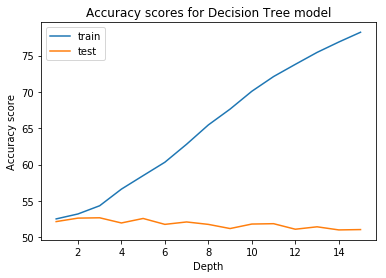

In [26]:
# ASSIGN X, y
X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

# GET DTs, SORES, CONFUSION MATRICES FOR EACH max_depth
max_depth = 15
DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices = DT_iterate(X, y, max_depth, class_names)

It looks like anything over a max depth of 2 (maybe even 1) would be constitute overfitting here. I suspect that this is because we're using K-folds (previous research, run with train_test_split, had train/test track until about max_depth = 5). However, we'll need to check the confusion matrices first befoew we can decide on a reasonable depth.

Let's check the accuracy scores for depth=2:

In [27]:
print(f"TRAIN ACCURACY, MAX DEPTH = 2: {round(DT_train_scores[1],3)}")
print(f"TEST ACCURACY, MAX DEPTH = 2: {round(DT_test_scores[1],3)}")

TRAIN ACCURACY, MAX DEPTH = 2: 53.213
TEST ACCURACY, MAX DEPTH = 2: 52.642


Our DT test accuracy is about 53%. This is barely an increase on our baseline of 52% (majority class).

Let's look at the confusion matrix for this model.

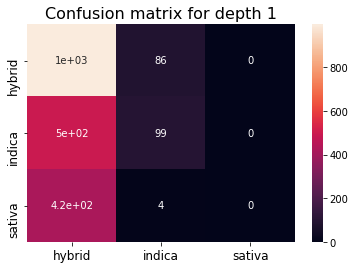

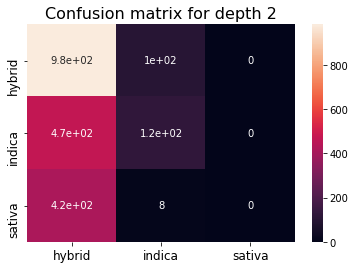

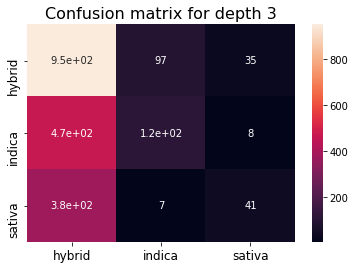

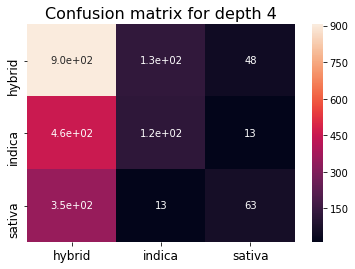

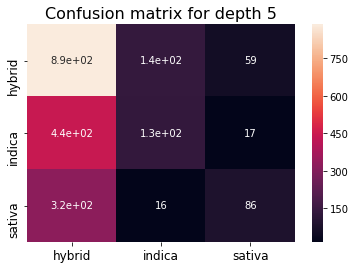

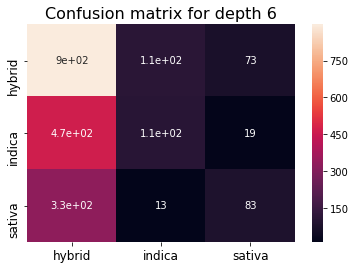

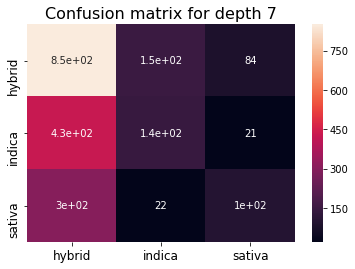

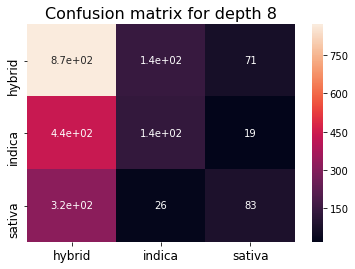

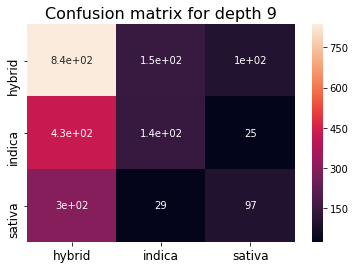

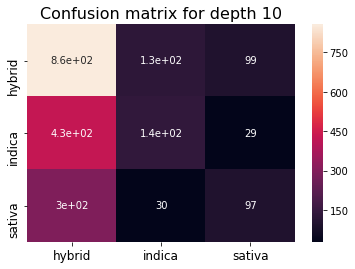

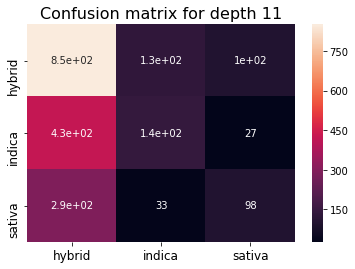

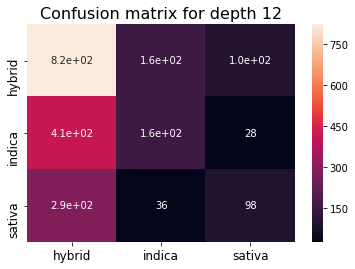

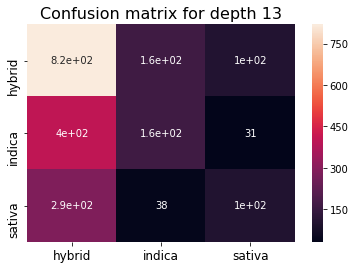

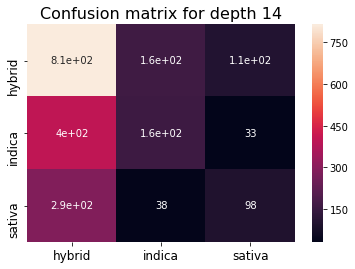

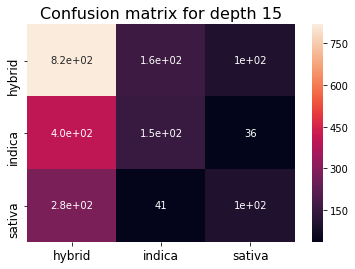

In [28]:
for i in range(0,max_depth):
    display_cf_matrix(DT_confusion_matrices, i)

It appears as our model is NOT learning to predict indica strains to a reasonable degree until at least depth 3 - depths 1 has no indica predictions at all!

That said, this model - even for higher depths - assigns more true sativas and indicas to "hybrid" than their correct class. This is a significant problem.

Interestingly, despite the confusion between hybrid and indica/sativa, there seems to be little confusion between indica and sativa. Let's see what happens if just train/predict on sativa/indica.

### 2.2 Single Decision Tree: Indica / Sativa only

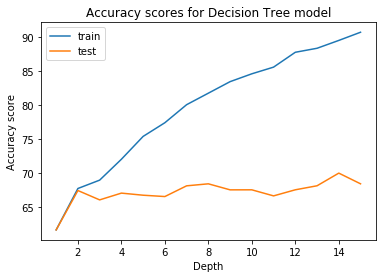

In [29]:
# DECISION TREE FOR SATIVA/INDICA ONLY

# ASSIGN X, y
sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

# GET DTs, SORES, CONFUSION MATRICES FOR EACH max_depth
max_depth = 15
DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices = DT_iterate(X, y, max_depth, class_names)

Focusing on sativa/indica is much more promising! At least our test results are increasing beyond a depth of 1.

A max depth of about 15 seems reasonable here. Let's look at accuracy scores and the confusion matrix for max depth = 15.

TRAIN ACCURACY, MAX DEPTH = 5: 81.80204268439564
TEST ACCURACY, MAX DEPTH = 5: 68.46631721995729


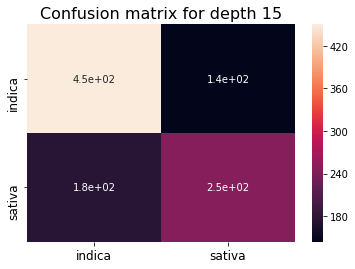

In [30]:
print(f"TRAIN ACCURACY, MAX DEPTH = 5: {DT_train_scores[7]}")
print(f"TEST ACCURACY, MAX DEPTH = 5: {DT_test_scores[7]}")
display_cf_matrix(DT_confusion_matrices, 14)

As we can see, this is a much more reasonable confusion matrix. Our accuracy for our test group is about 67.8%, which more cleanly beats our baseline of 58% by nearly 10%.

Now that we have results for a single decision tree, let's move onto random forests.

## 3. Random Forests: predict Strain_type from TF-IDF

As above, let's start with hybrid/indica/sativa and move on to indica/sativa.

### 3.1 Random Forest: Hybrid / Indica / Sativa

In [31]:
# RANDOM FOREST CREATOR FUNCTION USING K-FOLDS
# THIS FUNCTION WILL EXPLORE THE HYPER_PARAMETERS: MAX_DEPTH (STARTING FROM MIN_DEPTH), N_TREES
# 

def RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=1):
    
    RF_train_scores = [0]*(max_depth-min_depth+1)
    RF_test_scores = [0]*(max_depth-min_depth+1)
    
    # Generate a confusion matrices for each depth
    # RF_confusion_matrices[n] is the list of confusion matrices for n trees
    RF_confusion_matrices = [np.zeros([len(class_names), len(class_names)])]*(max_depth-min_depth+1)
            
    # Iterate over all depths
    for depth in range(min_depth,max_depth+1):

        # USE stratified k-folds TO GENERATE TRAIN/TEST SETS FOR CROSS-VALIDATION (ENSURES BALANCE BETWEEN CLASSES)
        folds = StratifiedKFold(n_splits = 5)
        indices = folds.split(X,y) # SPLIT df "X", stratified on y

        # For each fold
        for train_index, test_index in indices:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Set Train, Test X
            y_train, y_test = y[train_index], y[test_index] # Set Train, Test y

            # Instantiate, Fit RF_model - we'll keep max_features at auto (sqrt)
            RF_model = RandomForestClassifier(n_estimators=n_trees, max_depth=depth,\
                                          class_weight='balanced') # even though we've stratified, let's do this anyway
            RF_model.fit(X_train, y_train)

            # Generate predictions for confusion matrix, append to RF_confusion_matrices
            y_pred = RF_model.predict(X_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
            RF_confusion_matrices[depth-min_depth] = RF_confusion_matrices[depth-min_depth] + confusion_matrix
            
            # RF predict, evaluate, scaled by folds.n_splits-1            
            RF_train_scores[depth-min_depth] += RF_model.score(X_train, y_train)*100/(folds.n_splits)
            RF_test_scores[depth-min_depth] += RF_model.score(X_test, y_test)*100/(folds.n_splits)
            
    plt.figure()
    plt.plot(np.arange(min_depth,max_depth+1), RF_train_scores, label = "train scores")
    plt.plot(np.arange(min_depth,max_depth+1), RF_test_scores, label = "test scores")
    plt.xlabel("Depth")
    plt.ylabel("Accuracy score")
    plt.title("Accuracy scores for Random Forest model")
    plt.legend()
    plt.show()
    
    return(RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices)

Let's examine our Random Forest for n_trees=200, max_depth=15.

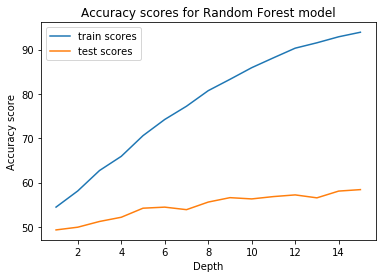

In [32]:
# Random Forest for SATIVA/INDICA/HYBRID
# n_trees = 200, max_depth = 15

X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

max_depth = 15
n_trees = 200

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names)

In [33]:
# GET TEST SCORE FOR max_depth (15)
print(f"Test score for max_depth = 15, n_trees = 200: {RF_test_scores[-1]}")

Test score for max_depth = 15, n_trees = 200: 58.397620048826454


Unlike our individual Decision Tree, our Random Forest's test data's accuracy increases consistently - albeit gradually - with depth. This is encouraging to see as it looks our model can actually learn from a greater depth.

Let's now check our confusion matrices.

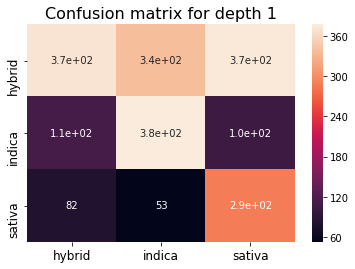

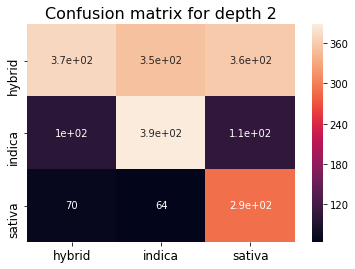

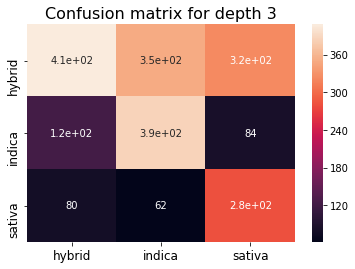

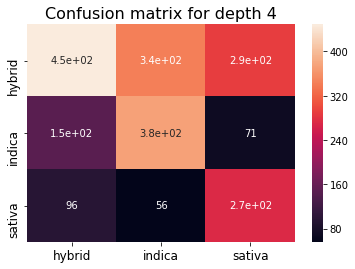

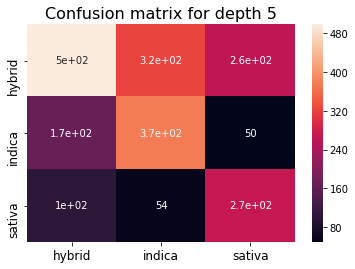

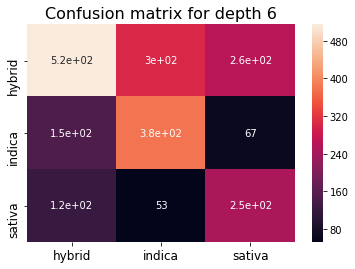

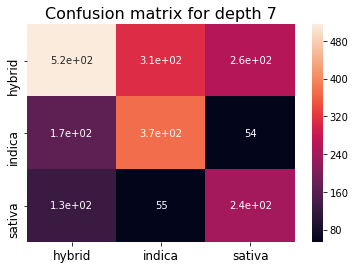

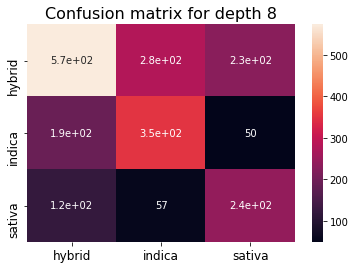

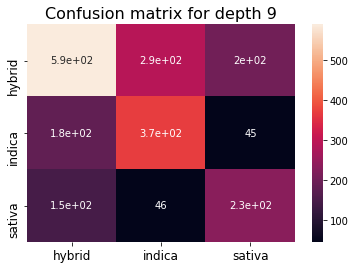

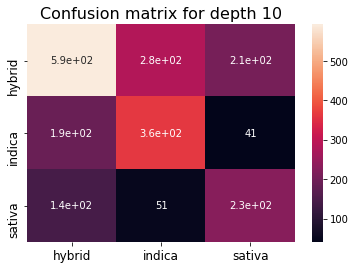

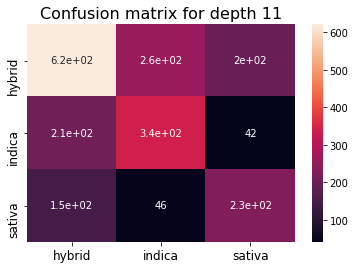

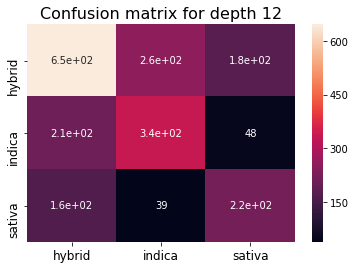

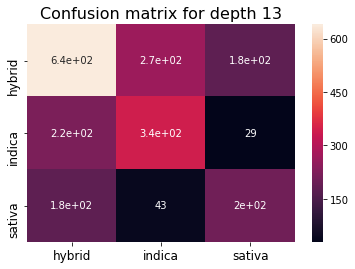

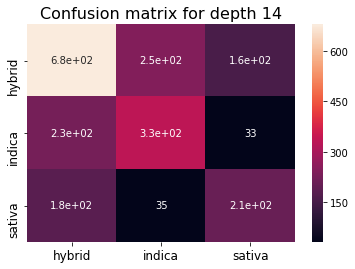

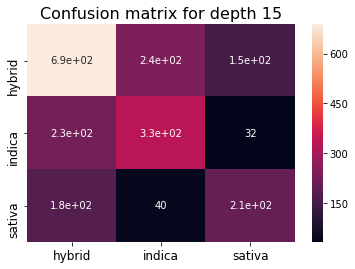

In [34]:
# Confusion Matrix
for i in range(0, max_depth):
    display_cf_matrix(RF_confusion_matrices, i)

Our confusion matrices show clear improvement (with expected variation) for subsequent depths! Again, this is promising.

However, as with our single decision tree, our while there is little confusion between sativa and indicas, these strains are often confused with hybris.

Let's check our results for a deeper and larger Random Forest: depth=50, trees=500. We'll check two depths below and above 50 for consistency/movement.

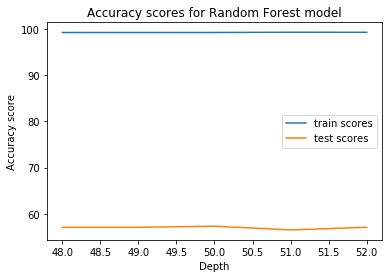

In [35]:
X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

min_depth = 48
max_depth = 52
n_trees = 500

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=min_depth)

In [36]:
print(RF_train_scores)
print(RF_test_scores)

[99.2384419507893, 99.25033254878936, 99.25031132817989, 99.2979232938466, 99.28601853194183]
[57.06677999252071, 57.06655539734675, 57.30317696638487, 56.49682346656968, 57.06712419138972]


A greater max_depth and more trees does not increase our test scores by a perceptible degree - depth=50, tree=500 is functionally equivalent to depth=15, trees=200, (56.6 vs 58.6, well within error/acceptible variation).

So it looks like we're topping out below 60% accuracy score for hybrid / indica / sativa. While this is a clear improvement on a single decision tree (53%), we will likely do better if we exclude hybrid strains and just focus on indica / sativa classification.

Let's now look at our confusion matrices.

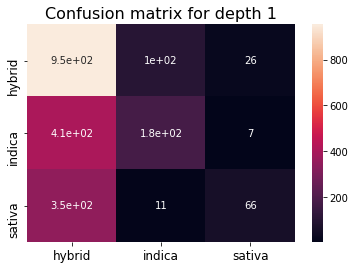

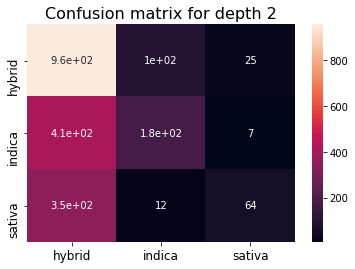

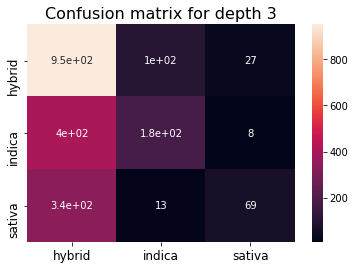

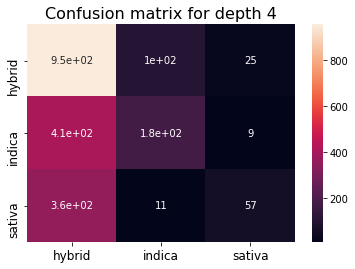

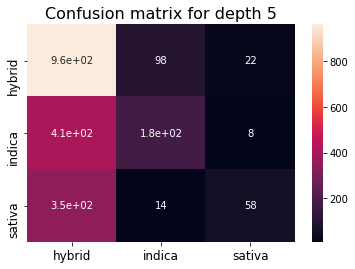

In [37]:
# Confusion Matrix
for i in range(0, max_depth-min_depth+1):
    display_cf_matrix(RF_confusion_matrices, i)

As before, more indica and sativa strains are classified as hybrid than their proper strain type. In fact, nearly all sativa strains are classified as hybrid! For better results we will surely have to look at indica/sativa only.

### 3.2 Random Forest: Indica / Sativa only

As with our decision tree, let's see if we can get obtain higher predictive accuracy by omitting "hybrid" strains. Let's also go deeper and use a max_depth of 25.

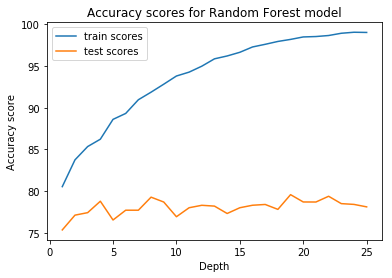

In [38]:
# Random Forest for Indica/Sativa classes, max_depth=25, n_trees = 200

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

max_depth = 25
n_trees = 200

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names)

In [39]:
print(np.mean(RF_test_scores[5:15]), np.mean(RF_test_scores[10:20]), np.mean(RF_test_scores[15:25]), np.mean(RF_test_scores[5:25]))

78.00242671325955 78.24995146573482 78.57639293341099 78.28940982333528


The accuracy stores start around 78.3 and seem to waver only very slightly. Let's check the confusion matrics.

### Confusion Matrix

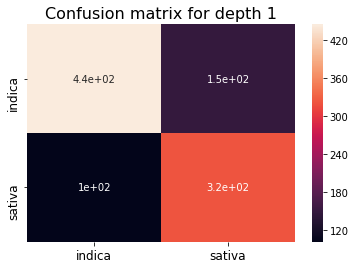

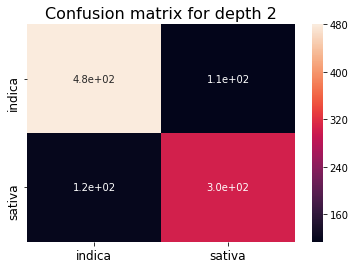

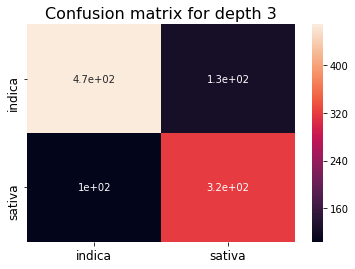

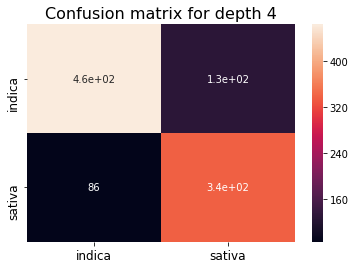

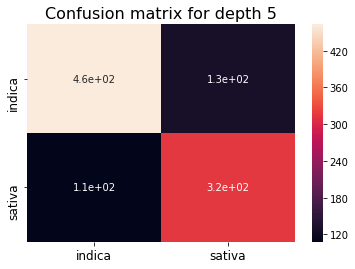

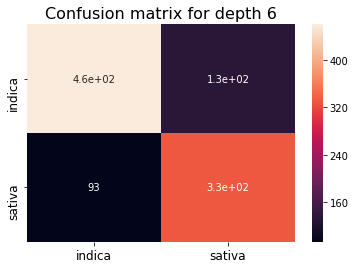

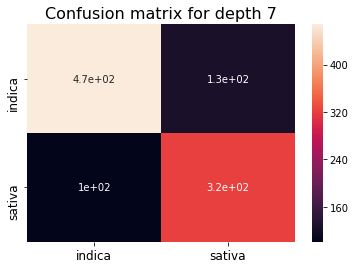

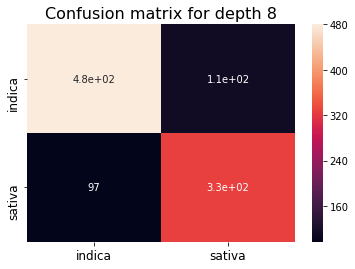

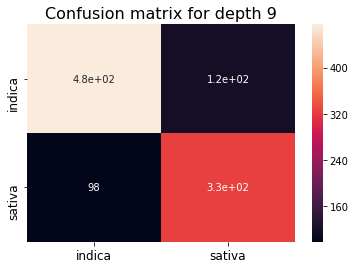

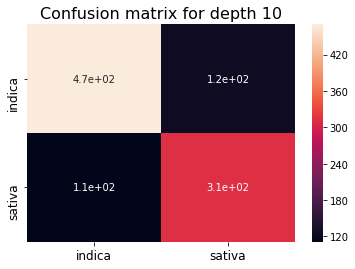

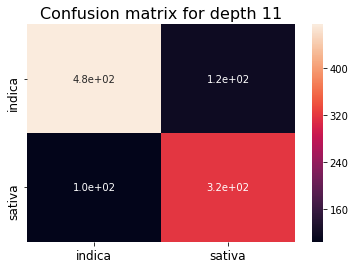

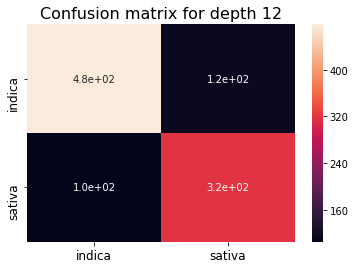

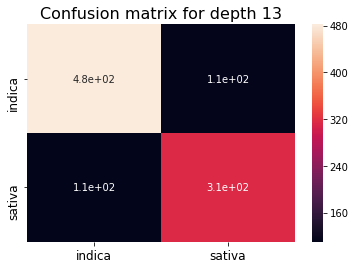

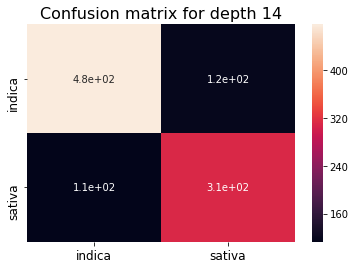

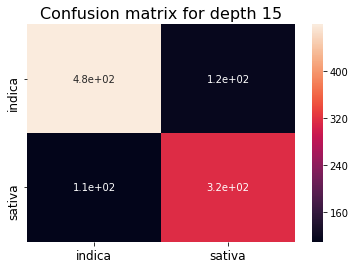

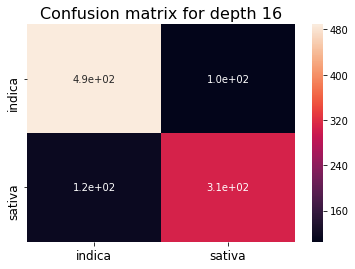

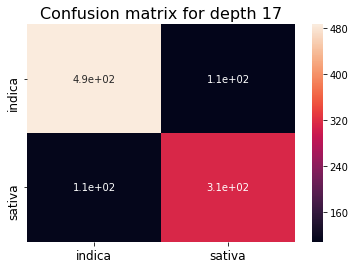

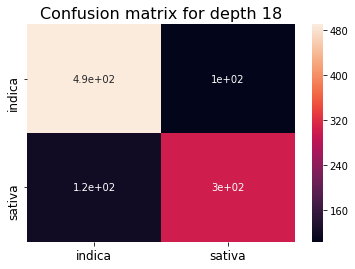

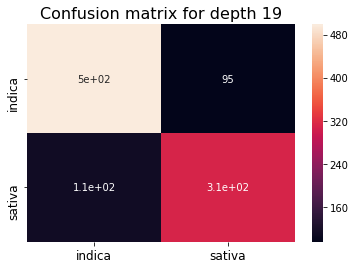

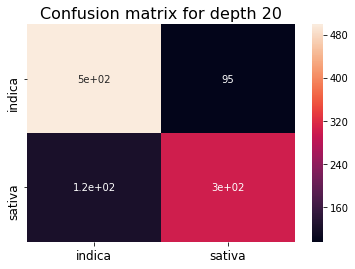

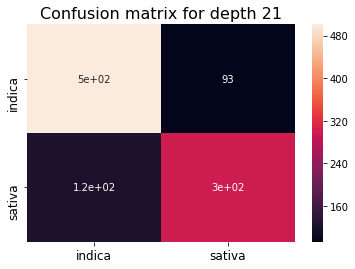

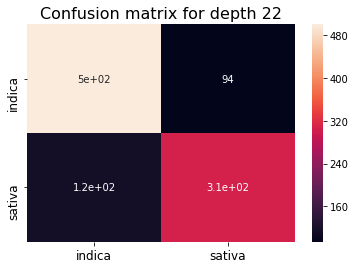

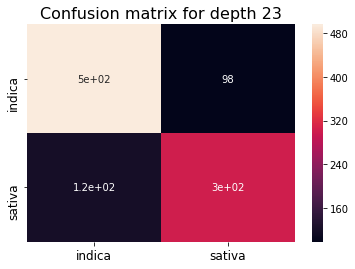

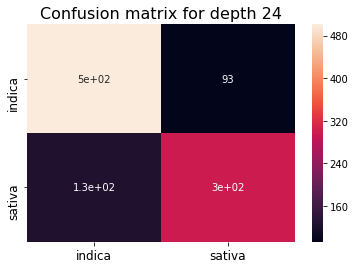

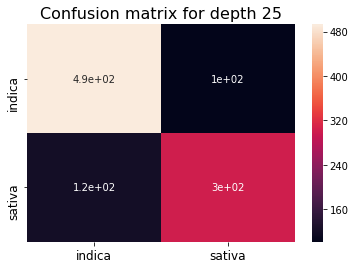

In [40]:
for i in range(0, max_depth):
    display_cf_matrix(RF_confusion_matrices, i)

Our confusion matrices are fairly consistent for most depths and, overall, do appear to be increasing. Do we dare see if this holds for, say a depth of 50 with 500 trees, as we did for hyrbid/sativa/indica strains?

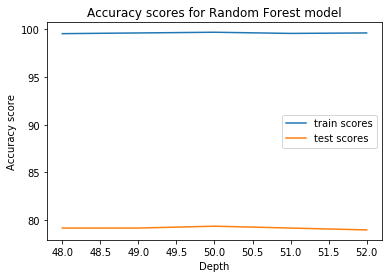

In [41]:
# Random Forest for Indica/Sativa classes, max_depth=48-52, n_trees = 500

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

min_depth = 48
max_depth = 52
n_trees = 500

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=min_depth)

In [42]:
np.mean(RF_test_scores)

79.17744127353912

The test scores average 79.3%. Not as good as what we achieved for fewer trees at a lower depth, but at least they're consistent.

On average, our best scores for sativa/indica only for a random forest (~79.3%) is over 11% higher than for a single decision tree (~68.7%), and clearly better than randomly guessing (50%, given our balanced sampling due to Strafied K-folds).

### 3.3: Random Forest, Sativa/Indica only, TF-IDF

Let's use norm_data_df, our TF-IDF dataframe, with the hyper-parameters we most recently examined for our best models (max_depth: 1-25, n_estimators=200 ; max_depth=48-52, n_estimators=500).

In [43]:
# Blind the data (remove strain labels)
norm_data_df_blind = norm_data_df.drop(labels=["hybrid", "sativa", "indica"], axis=1)

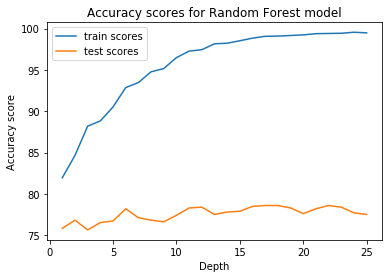

In [44]:
# TF-IDF Random Forest for Indica/Sativa classes, max_depth=25, n_trees = 200

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = norm_data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

max_depth = 25
n_trees = 200

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names)

In [45]:
print(np.mean(RF_test_scores[5:15]), np.mean(RF_test_scores[10:20]), np.mean(RF_test_scores[15:25]), np.mean(RF_test_scores[5:25]))

77.59978644923316 78.141622985828 78.1919044845661 77.89584546689963


These accuracy scores are close to, but somewhat lower than for word count.

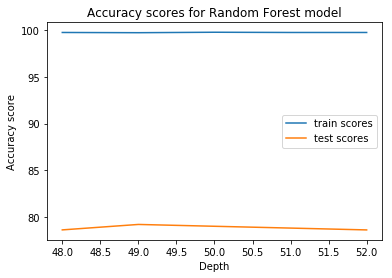

In [46]:
# IF-IDF Random Forest for Indica/Sativa classes, max_depth=48-52, n_trees = 500

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = norm_data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

min_depth = 48
max_depth = 52
n_trees = 500

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=min_depth)

In [47]:
np.mean(RF_test_scores)

78.8213939040963

Again, this score is lower than for simply using word count (by about 0.6%). In the end it was not worth using TF-IDF over word count for our model - we'll stick to word count for our future analysis of the most important features (that is, the most important lemmatized terms).

### 3.4 Best RF model (sativa/indica only)

Our best RF model that we will use has the following hyper-parameters: max_depth=50, n_estimators=500. Admittedly there is a lot of room for varying these hyper-parameters, but let's stick to these for now since I doubt any more fine tuning will alter the model's most important features.

Let's create a similar RF model, but this time we'll include ALL our data (no train-test splitting).

Remember, we're not making this model for prediction on a particular strain, but for gaining insight into its learned most important features (lemmatized terms), so the overly predictive powers of this model (overfitting) aren't an issue.

In [48]:
# Define X, y (sativa/indica only)
sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

# Instantiate, Fit RF_model
# We absolutely need to use class_weight='balanced' since we're using stratified K-folds like we did above
RF_model = RandomForestClassifier(n_estimators=500, max_depth=50, class_weight='balanced', oob_score=True)
RF_model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

Model created! Now let's examine the model's most important terms.

## 4. Most important features (terms)

What are the most critical features (terms) for our indica/sativa only RF model? Which words (or, more specifically, which lemmatized words) are helpful in distinguishing indica strains from sativa strains?

### 4.1 Feature importance

In [412]:
# GET MOST IMPORTANT FEATURES & THEIR VALUES (FEATURE IMPORTANCES)
feature_list = list(data_df_blind.columns)
importances = list(RF_model.feature_importances_)

feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) # SORT THE FEATURES

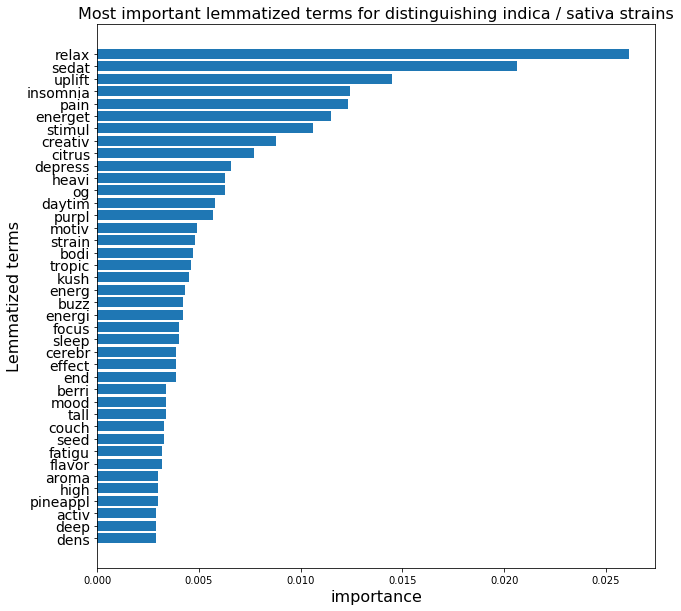

In [413]:
# VISUALIZE MOST IMPORTANT FEATURES
top_features = 40

features = [feature_importances[i][0] for i in range(0,top_features)]
importances = [feature_importances[i][1] for i in range(0,top_features)]

plt.figure(figsize=(10,10))
plt.barh(y=features, width=importances)
plt.xlabel(xlabel="importance",fontsize=16)
plt.ylabel(ylabel="Lemmatized terms", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.title("Most important lemmatized terms for distinguishing indica / sativa strains", fontsize=16)
plt.gca().invert_yaxis()
plt.show()

From this list of terms we can immediately recognize some as being indicative of typically-associated effects, flavours, and medical uses for indica/sativa strains.

For example, we know (from my previous work, among other sources) that indica strains are often described as relax[ing], sedat[ive], and good for imsomnia and pain, while sativas are often described as energet[ic], uplift[ing], creat[ive], citrus flavoured and good for depress[ion] and daytim[e] use.

To check how these features are likely leading the classifier to make its decision (sativa/indica), let's look at the total average word count for these terms in sativa and indica strains. We will display these on the same graph as a scaled version of the Feature Importance for visual clarity.

In [439]:
# GET LIST OF SATIVA, INDICA STRAINS
sativas = sativa_indica_only[sativa_indica_only['Strain_type'].values == 'sativa'].index.values
indicas = sativa_indica_only[sativa_indica_only['Strain_type'].values == 'indica'].index.values

# SUBSET FOR SATIVA/INDICA (ROWS) AND MOST IMPORTANT FEATURES (COLUMNS)
df_sativa_important_features = data_df[features].loc[sativas]
df_indica_important_features = data_df[features].loc[indicas]

# CHECK SHAPES OF DFs
print(df_sativa_important_features.shape, df_indica_important_features.shape)

(424, 40) (594, 40)


In [440]:
# SET GRAPH LABELS, GET WORD COUNT MEANS FOR SATIVA/INDICA STRAINS, MOST IMPORTANT FEATURES
sativa_indica_labels = df_sativa_important_features.mean().index

sativa_means = df_sativa_important_features.mean().values
indica_means = df_indica_important_features.mean().values
sativa_indica_means_diff = sativa_means-indica_means

In [441]:
# MAKE A SORTABLE DF OF MEANS_DIFF, FEATURE IMPORTANCES
data=np.array([sativa_indica_means_diff, importances]).T
df_FI = pd.DataFrame(data=data, index=sativa_indica_labels, columns=["Mean Difference","Feature Importance"])
df_FI.sort_values(by="Mean Difference", inplace=True)

df_FI["Mean Difference"].values

array([-0.31976209, -0.20865892, -0.20739629, -0.14338352, -0.13086049,
       -0.12087066, -0.10030335, -0.08785179, -0.08146719, -0.08110984,
       -0.07065942, -0.06141605, -0.05922432, -0.05891462, -0.05688965,
       -0.04747157, -0.0112604 ,  0.00215202,  0.03496442,  0.04076933,
        0.04751128,  0.05136268,  0.05290325,  0.05458675,  0.05627025,
        0.06032812,  0.064386  ,  0.06907916,  0.0701512 ,  0.07043708,
        0.07232704,  0.07823518,  0.07886252,  0.08323804,  0.08728797,
        0.10411505,  0.12505559,  0.15401658,  0.16210057,  0.1813179 ])

In [443]:
# SET MASKED FEATURES (INDICA, SATIVA LEANING), FILL MASKED VALUES WITH "0"
sativa_leaning_means_diff = np.ma.masked_where(df_FI["Mean Difference"].values < 0, df_FI["Mean Difference"].values).filled(0)
indica_leaning_means_diff = np.ma.masked_where(df_FI["Mean Difference"].values > 0, df_FI["Mean Difference"].values).filled(0)

In [444]:
# SCALED FI SO VISIBLE ON GRAPH
FI_scaled = [8*i for i in df_FI["Feature Importance"].values]

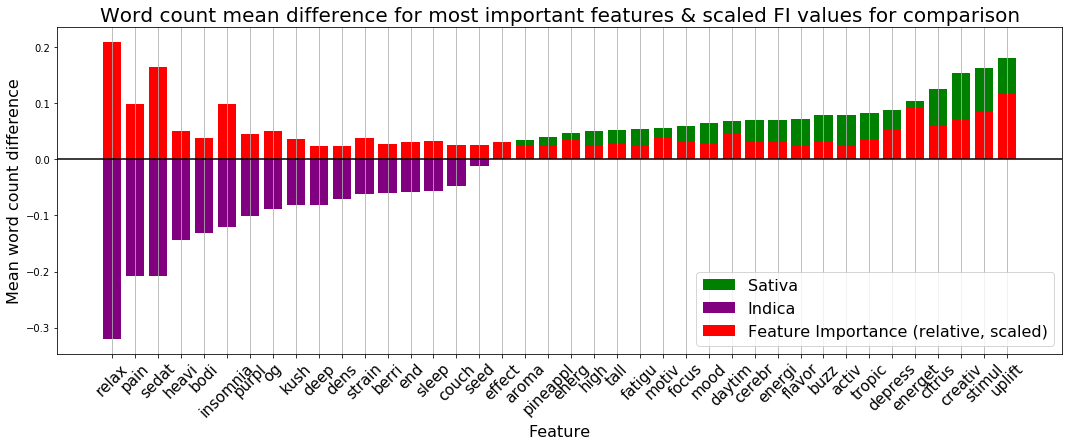

In [445]:
# GRAPH WORD COUNT MEAN DIFFERENCE VS MOST IMPORTANT FEAUTRES
plt.figure(figsize=(18,6))
plt.bar(df_FI.index, sativa_leaning_means_diff, color="green", label="Sativa")
plt.bar(df_FI.index, indica_leaning_means_diff, color="purple", label="Indica")
plt.bar(df_FI.index, FI_scaled, color="red", label="Feature Importance (relative, scaled)")
plt.axhline(y=0, c="k")
plt.xticks(fontsize=15, rotation=45)
plt.grid(axis='x')
plt.title("Word count mean difference for most important features & scaled FI values for comparison", fontsize=20)
plt.ylabel("Mean word count difference", fontsize=16)
plt.xlabel("Feature", fontsize=16)
plt.legend(fontsize=16)
plt.show()

This graph helps us clearly see how commonly the most important features are represented in indica/sativa strain descriptions.

Critically, we see here that the most important features identified by our model are not necessarily the ones that have the strongest word count difference - for example "pain" has a slightly less FI-value than "insomnia" (assumedly for identifying indica strains), although its word count for indica strains is higher. On the sativa side, the same goes for "citrus" and "depress[ion]" - depression has a higher FI-value.

Let's produce a similar graph, but in order of descending feature importance.

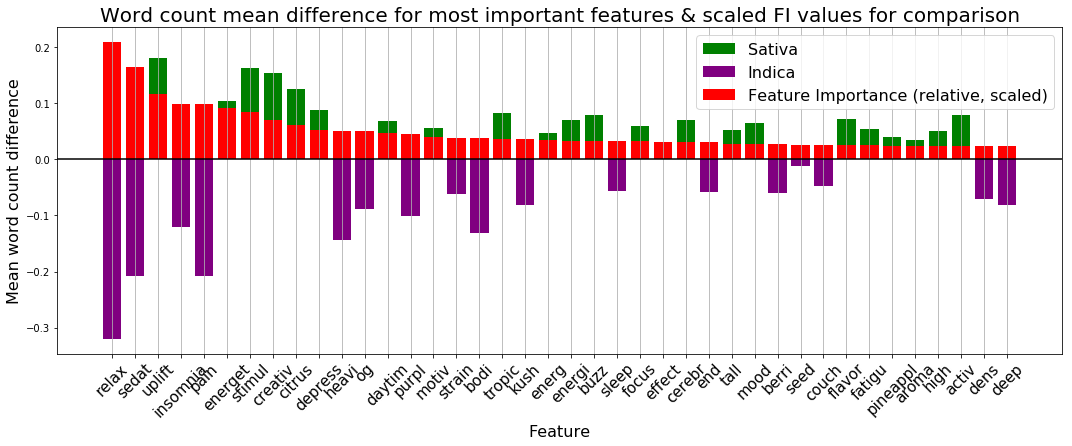

In [446]:
# GRAPH WORD COUNT MEAN DIFFERENCE VS MOST IMPORTANT FEAUTRES (ORDERED BY FI)

# RESORT df_FI ACCORDING TO FEATURE IMPORTANCE
df_FI.sort_values(by="Feature Importance", ascending=False, inplace=True)

# SET MASKED FEATURES (INDICA, SATIVA LEANING), FILL MASKED VALUES WITH "0"
sativa_leaning_means_diff = np.ma.masked_where(df_FI["Mean Difference"].values < 0, df_FI["Mean Difference"].values).filled(0)
indica_leaning_means_diff = np.ma.masked_where(df_FI["Mean Difference"].values > 0, df_FI["Mean Difference"].values).filled(0)

# SCALED FI SO VISIBLE ON GRAPH
FI_scaled = [8*i for i in df_FI["Feature Importance"].values]

# GRAPH WORD COUNT MEAN DIFFERENCE VS MOST IMPORTANT FEAUTRES
plt.figure(figsize=(18,6))
plt.bar(df_FI.index, sativa_leaning_means_diff, color="green", label="Sativa")
plt.bar(df_FI.index, indica_leaning_means_diff, color="purple", label="Indica")
plt.bar(df_FI.index, FI_scaled, color="red", label="Feature Importance (relative, scaled)")
plt.axhline(y=0, c="k")
plt.xticks(fontsize=15, rotation=45)
plt.grid(axis='x')
plt.title("Word count mean difference for most important features & scaled FI values for comparison", fontsize=20)
plt.ylabel("Mean word count difference", fontsize=16)
plt.xlabel("Feature", fontsize=16)
plt.legend(fontsize=16)
plt.show()

Now let's look at the most important features another way: by examining Permutation Improtance.

### 4.2 Permutation importance

It is a known issue that feature importance for random forests may in some cases be highly biased. On this basis we will also consider the permuation importance (more on this problem, and resolution, here: https://explained.ai/rf-importance/)

In [421]:
# GET PERMUTATION IMPORTANCES
perm = PermutationImportance(RF_model).fit(X, y) # We can call this on the same X, y for understanding the model

KeyboardInterrupt: 

In [ ]:
# DISPLAY PERMUTATION IMPORTANCE VALUES (WEIGHTS)
eli5.show_weights(estimator = perm, feature_names = X.columns.tolist())

In [ ]:
# EXPORT WEIGHTS TO DF
df_perm_importances = eli5.formatters.as_dataframe.explain_weights_df(perm, feature_names = X.columns.tolist())

In [ ]:
# CHECK df_perm_importances
df_perm_importances[0:5]

In [362]:
# EXPORT THE DF TO FILE
df_perm_importances.to_csv('df_perm_importances.csv')

In [447]:
# LOAD DF FROM FILE
df_perm_importances = pd.read_csv('df_perm_importances.csv')
df_perm_importances.shape

(4907, 4)

We can use permutation importance for feature selection as well. (see https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html). As with our previous feature importance, we will have to make a judgement call for how many features to selection.

Because we have a measure of precision, let's use that as a cutoff instead of running something like recursive feature elimination, which requires you have to select n features (default n=half of all features).

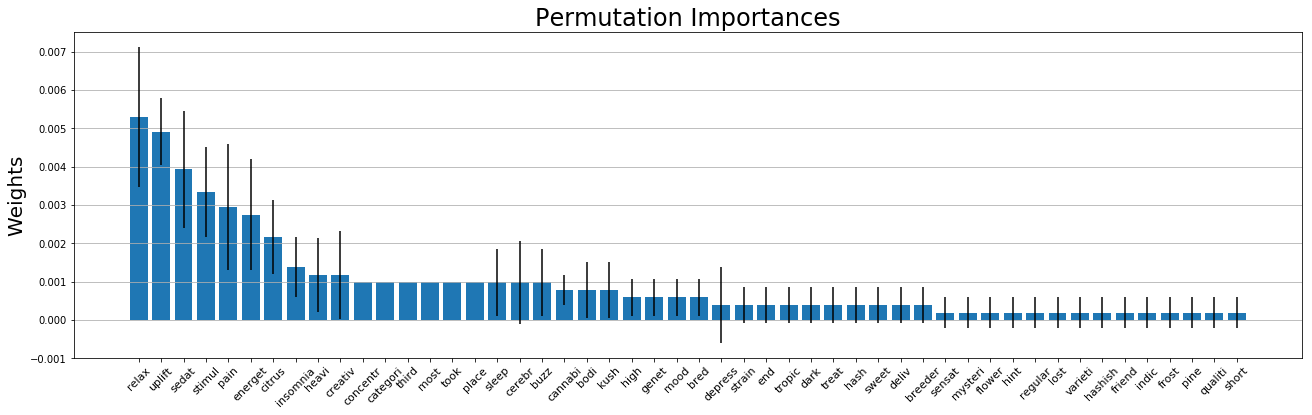

In [448]:
# GRAPH PERMUTATION IMPORTANCES
p_features = df_perm_importances["feature"].values[0:50]
values = df_perm_importances["weight"].values[0:50]
errors = df_perm_importances["std"].values[0:50]
x = np.arange(len(p_features))

fig, ax = plt.subplots(figsize=(22,6))
ax.bar(x=x, height=values, yerr=errors, align='center')
ax.set_ylabel('Weights', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(p_features, rotation=45, fontsize=11)
ax.set_title('Permutation Importances', fontsize=24)
ax.yaxis.grid(True)

Unsurprisingly, we have a perhaps a little surprisingly long dropoff and a long tail.

Upon inspection, the error margin for the weights crosses the x-axis (probability of occurrence = 0%) from "depress" on (although "cerebr" also crosses the threshold). Since our decision to start at 50 was arbitrary, I might as well use this cutoff for the the first 26 terms to analyze.

If we exclude everything from that term on, we get a tighter graph.

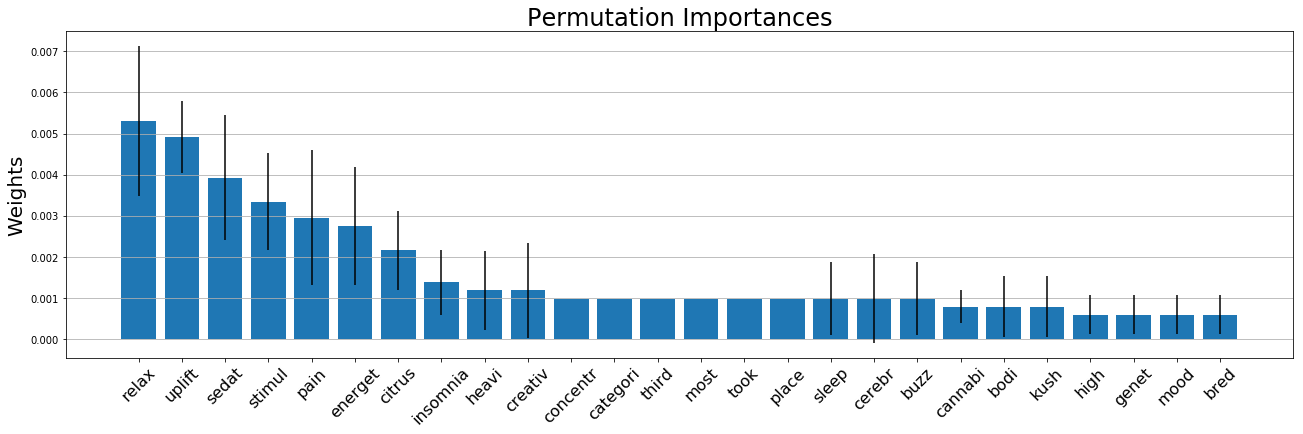

In [449]:
# GRAPH PERMUTATION IMPORTANCES
p_features = df_perm_importances["feature"].values[0:26]
values = df_perm_importances["weight"].values[0:26]
errors = df_perm_importances["std"].values[0:26]
x = np.arange(len(p_features))

fig, ax = plt.subplots(figsize=(22,6))
ax.bar(x=x, height=values, yerr=errors, align='center')
ax.set_ylabel('Weights', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(p_features, rotation=45, fontsize=16)
ax.set_title('Permutation Importances', fontsize=24)
ax.yaxis.grid(True)

Great. Now let's look at the word count difference by each of these features.

In [451]:
# SET importances
p_importances = df_perm_importances["weight"].values[0:26]

In [452]:
# SUBSET FOR SATIVA/INDICA (ROWS) AND HIGHEST-RANKED PERMUTATION-IMPORTANT FEATURES (COLUMNS)
df_sativa_important_features = data_df[p_features].loc[sativas]
df_indica_important_features = data_df[p_features].loc[indicas]

# CHECK SHAPES OF DFs
print(df_sativa_important_features.shape, df_indica_important_features.shape)

(424, 26) (594, 26)


In [453]:
# SET GRAPH LABELS, GET WORD COUNT MEANS FOR SATIVA/INDICA STRAINS, HIGHEST PERM FEATURES
sativa_indica_labels = df_sativa_important_features.mean().index

sativa_means = df_sativa_important_features.mean().values
indica_means = df_indica_important_features.mean().values
sativa_indica_means_diff = sativa_means-indica_means

# MAKE A SORTABLE DF OF MEANS_DIFF, PERM IMPORTANCES
data=np.array([sativa_indica_means_diff, p_importances]).T
df_PI = pd.DataFrame(data=data, index=sativa_indica_labels, columns=["Mean Difference","Permutation Importance"])

# RESORT df_PI ACCORDING TO PERM IMPORTANCES
df_PI.sort_values(by="Permutation Importance", ascending=False, inplace=True)

# SET MASKED FEATURES (INDICA, SATIVA LEANING), FILL MASKED VALUES WITH "0"
sativa_leaning_means_diff = np.ma.masked_where(df_PI["Mean Difference"].values < 0,\
                                               df_PI["Mean Difference"].values).filled(0)
indica_leaning_means_diff = np.ma.masked_where(df_PI["Mean Difference"].values > 0,\
                                               df_PI["Mean Difference"].values).filled(0)

# SCALED FI SO VISIBLE ON GRAPH
PI_scaled = [30*i for i in df_PI["Permutation Importance"].values]

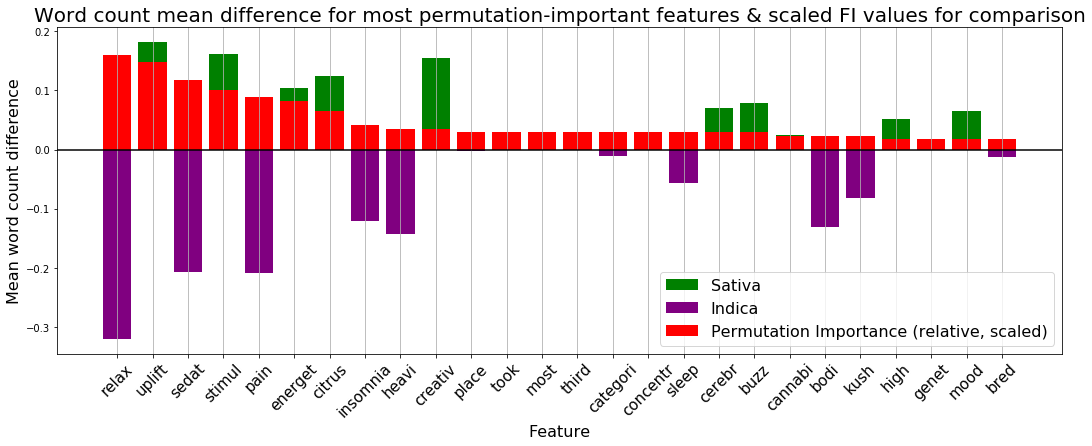

In [454]:
# GRAPH WORD COUNT MEAN DIFFERENCE VS MOST PERM-IMPORTANT FEAUTRES (ORDERED BY PI)
plt.figure(figsize=(18,6))
plt.bar(df_PI.index, sativa_leaning_means_diff, color="green", label="Sativa")
plt.bar(df_PI.index, indica_leaning_means_diff, color="purple", label="Indica")
plt.bar(df_PI.index, PI_scaled, color="red", label="Permutation Importance (relative, scaled)")
plt.axhline(y=0, c="k")
plt.xticks(fontsize=15, rotation=45)
plt.grid(axis='x')
plt.title("Word count mean difference for most permutation-important features & scaled FI values for comparison", fontsize=20)
plt.ylabel("Mean word count difference", fontsize=16)
plt.xlabel("Feature", fontsize=16)
plt.legend(fontsize=16)
plt.show()

As in our previous graph we have scaled the Permutation Importance so it is nicely visible on the graph - its absolute values are not important here, but rather its relative values (more/less important).

By inspection, many if not most of the features in this graph of the top 26 perm-important features are also in the top-26 most important features. Let's look at which features are in one list and not the other:

In [465]:
in_PI_not_FI = [i for i in df_PI.index if i not in df_FI.index[0:26]]
in_FI_not_PI = [i for i in df_FI.index[0:26] if i not in df_PI.index]
print("In PI but not in FI:\n", in_PI_not_FI)
print("In FI but not in PI:\n", in_FI_not_PI)

In PI but not in FI:
 ['place', 'took', 'most', 'third', 'categori', 'concentr', 'cannabi', 'high', 'genet', 'mood', 'bred']
In FI but not in PI:
 ['depress', 'og', 'daytim', 'purpl', 'motiv', 'strain', 'tropic', 'energ', 'energi', 'focus', 'effect']


These results tell us something interesting: while the top 26 PI terms include some not-particularly-helpful terms for understanding the sativa/indica split, like "place", "took", and "most", the top 26 FI terms include some very meaningful terms such as "depression[ion]", "daytim[e]", and "focus".

Due to this finding, we should consider feature importance more useful than permutation importance. We will use FI, not PI, going forward.

### 5. What about XGBoost?

Let's try XGBoost instead of a Random Forest. As above, we'll use stratified 5-fold validation.

In [467]:
from xgboost import XGBClassifier

In [479]:
# XGBoost MODEL CREATOR FUNCTION USING K-FOLDS
# THIS FUNCTION WILL EXPLORE THE HYPER_PARAMETERS: MAX_DEPTH (STARTING FROM MIN_DEPTH), N_ESTIMATORS

def XGB_iterate(X, y, max_depth, n_estimators, class_names, min_depth=1):
    
    pos_over_neg = len(sativas)/len(indicas) # sativas is positive group (1)

    XGB_train_scores = [0]*(max_depth-min_depth+1)
    XGB_test_scores = [0]*(max_depth-min_depth+1)
    
    # Generate a confusion matrices for each depth
    # RF_confusion_matrices[n] is the list of confusion matrices for n estimators
    XGB_confusion_matrices = [np.zeros([len(class_names), len(class_names)])]*(max_depth-min_depth+1)
            
    # Iterate over all depths
    for depth in range(min_depth,max_depth+1):

        # USE stratified k-folds TO GENERATE TRAIN/TEST SETS FOR CROSS-VALIDATION (ENSURES BALANCE BETWEEN CLASSES)
        folds = StratifiedKFold(n_splits = 5)
        indices = folds.split(X,y) # SPLIT df "X", stratified on y

        # For each fold
        for train_index, test_index in indices:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Set Train, Test X
            y_train, y_test = y[train_index], y[test_index] # Set Train, Test y

            # Instantiate, Fit XGB_model - we'll keep max_features at auto (sqrt)
            XGB_model = XGBClassifier(n_estimators=n_estimators, max_depth=depth, scale_pos_weight=pos_over_neg)
            XGB_model.fit(X_train, y_train)

            # Generate predictions for confusion matrix, append to RF_confusion_matrices
            y_pred = XGB_model.predict(X_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
            XGB_confusion_matrices[depth-min_depth] = XGB_confusion_matrices[depth-min_depth] + confusion_matrix
            
            # XGB predict, evaluate, scaled by folds.n_splits-1            
            XGB_train_scores[depth-min_depth] += XGB_model.score(X_train, y_train)*100/(folds.n_splits)
            XGB_test_scores[depth-min_depth] += XGB_model.score(X_test, y_test)*100/(folds.n_splits)
            
    plt.figure()
    plt.plot(np.arange(min_depth,max_depth+1), XGB_train_scores, label = "train scores")
    plt.plot(np.arange(min_depth,max_depth+1), XGB_test_scores, label = "test scores")
    plt.xlabel("Depth")
    plt.ylabel("Accuracy score")
    plt.title("Accuracy scores for XGBoost model")
    plt.legend()
    plt.show()
    
    return(XGB_model, XGB_train_scores, XGB_test_scores, XGB_confusion_matrices)

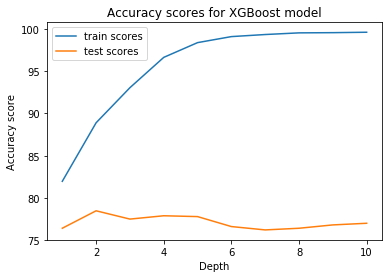

In [484]:
# XGBoost for Indica/Sativa classes, max_depth=10, n_trees = 300

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

min_depth = 1
max_depth = 10
n_estimators = 300

XGB_model, XGB_train_scores, XGB_test_scores, XGB_confusion_matrices = XGB_iterate(X, y, max_depth, n_estimators, class_names, min_depth=min_depth)

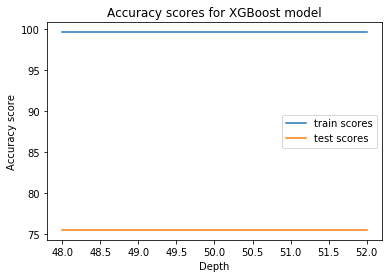

In [483]:
# XGBoost for Indica/Sativa classes, depth=[48:52], n_trees = 200

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

min_depth = 48
max_depth = 52
n_estimators = 200

XGB_model, XGB_train_scores, XGB_test_scores, XGB_confusion_matrices = XGB_iterate(X, y, max_depth, n_estimators, class_names, min_depth=min_depth)

Without any further hyperparameter searching we see that our out-of-the-box XGBoost model tops out at about 75% accuracy for 200 estimators. We saw a higher result for 300 estimators, depth=2 (closer to 80%), but seeing as we're not looking to max out accuracy but actually get a decent idea of our features, we don't need to tool around with this too much - it's not as if XGBoost is regularly beating 80% accuracy.

Let's take a moment and look at our XGB_model's most important features.

In [486]:
# GET MOST IMPORTANT FEATURES & THEIR VALUES (FEATURE IMPORTANCES)
XGB_feature_list = list(data_df_blind.columns)
XGB_importances = list(XGB_model.feature_importances_)

XGB_feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(XGB_feature_list, XGB_importances)]
XGB_feature_importances = sorted(XGB_feature_importances, key = lambda x: x[1], reverse = True) # SORT THE FEATURES

In [488]:
XGB_feature_importances[0:20]

[('spice', 0.0222),
 ('creativ', 0.0202),
 ('sedat', 0.0194),
 ('relax', 0.015),
 ('insomnia', 0.0148),
 ('energet', 0.0134),
 ('tall', 0.0128),
 ('thick', 0.0114),
 ('herbal', 0.0112),
 ('includ', 0.0108),
 ('mood', 0.0103),
 ('indigen', 0.01),
 ('uplift', 0.0095),
 ('motiv', 0.0093),
 ('structur', 0.0093),
 ('climat', 0.009),
 ('symptom', 0.0089),
 ('energi', 0.0081),
 ('euphor', 0.0081),
 ('sharp', 0.008)]

Interestingly we have a few new terms here in the list that we didn't before. In particular "spice" tops the list, a term that doesn't even register for our RF models.

Some interpretation: we should keep in mind that this random forest might have some issues should certain features be strongly correlated, the random sampling of random forest should mitigate this.

So let's take a look at the correlation of our strongest features!!!!

We're also just looking if a term is present, not how many times it's used or the context of its use, so there's that possible source of error.